<a href="https://colab.research.google.com/github/JasmineD0401/SMA-LABS/blob/main/Sentiment_analysis_(lab_05).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATASET**

[Hotel_Reviews.csv](https://drive.google.com/file/d/1CyMY40q3I4NaZgzgZfTLcL8nQU-bgUu-/view?usp=sharing)

# Load data

In [ ]:
import pandas as pd

# read data
reviews_df = pd.read_csv("/content/Hotel_Reviews.csv")
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


# Sample data

In [ ]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

Reviews data is sampled in order to speed up computations.

# Clean data

In [ ]:
import numpy as np

# Replace NaN values with an empty string
reviews_df["review"] = reviews_df["review"].fillna("")

# Remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: str(x).replace("No Negative", "").replace("No Positive", ""))


If the user doesn't leave any negative feedback comment, this will appear as "No Negative" in our data. This is the same for the positive comments with the default value "No Positive". We have to remove those parts from our texts.

The next step consists in cleaning the text data with various operations:

In [ ]:
import nltk
import nltk
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

# Feature engineering

In [ ]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:
- number of characters in the text
- number of words in the text

In [ ]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [ ]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)


Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:
- TF computes the classic number of times the word appears in the text
- IDF computes the relative importance of this word which depends on how many texts the word can be found

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [ ]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yard,word_year,word_yellow,word_yes,word_yet,word_yoghurt,word_yogurt,word_young,word_yummy,word_zero
12645,Not much Would like some more varaiety on bre...,0,much would like varaiety breakfast buffet perf...,0.092,0.609,0.300,0.6987,110,20,-0.016833,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
78438,unpredictability room s floor side view lay o...,0,unpredictability room floor side view lay mezz...,0.000,0.873,0.127,0.4404,152,25,0.033262,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
176696,slow service repeated key failure no cold wat...,1,slow service repeat key failure cold water sin...,0.372,0.628,0.000,-0.7717,83,18,0.124663,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
55682,The staff was wonderful so helpful and kind T...,0,staff wonderful helpful kind hotel quiet stree...,0.000,0.616,0.384,0.9689,235,44,-0.211067,...,0.0,0.0,0.0,0.0,0.315276,0.0,0.0,0.0,0.0,0.0
27783,Close to Victoria station all amenities Walki...,0,close victoria station amenity walk distance b...,0.000,1.000,0.000,0.0000,93,16,0.071219,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
reviews_df.shape

(25323, 2672)

# Exploratory data analysis


In order to have a better understanding of our data, let's explore it a little:

In [ ]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

is_bad_review
0    0.94969
1    0.05031
Name: proportion, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

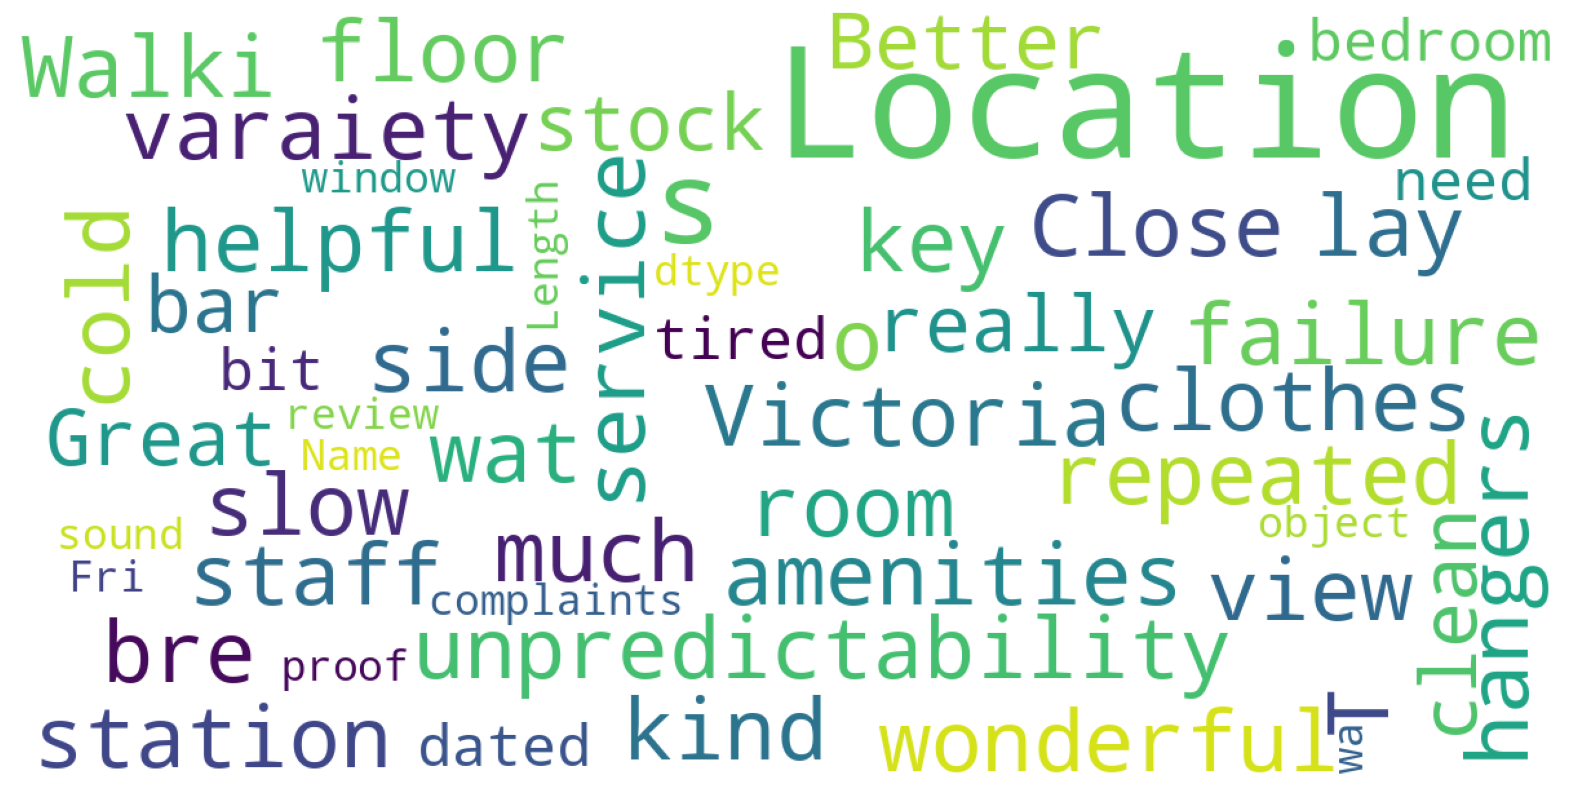

In [ ]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(reviews_df["review"])

Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [ ]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
211742,Clean comfortable lovely staff,0.907
23856,Excellent friendly helpful staff,0.907
221615,happy friendly helpful staff,0.907
244782,Price Clean Friendly Comfortable,0.902
168611,Friendly staff good value,0.895
84069,Good location good value,0.891
251685,FRIENDLY WELL ORGANISED CLEAN,0.889
126611,Lovely staff lovely welcome very nice,0.873
223673,all good Great Hotel great Value,0.871
128859,Clean tidy comfortable good value highly reco...,0.870


The most positive reviews indeed correspond to some good feedbacks.

In [ ]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
50365,no complaints no complaints,1.000
121068,Nothing Great staff excellent,0.759
162257,Poor service Poor service,0.756
182076,Rude arrogant staff Location,0.756
207881,Awful awful hotel experience,0.750
22978,Nothing Lovely comfortable surroundings,0.743
175316,Nothing Super friendly staff,0.743
126153,Nothing Clean and beautiful,0.730
246585,None Good courteous staff,0.719
140235,All goid no complaints,0.710


<ipython-input-33-9f6b95e7950f>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)
<ipython-input-33-9f6b95e7950f>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)


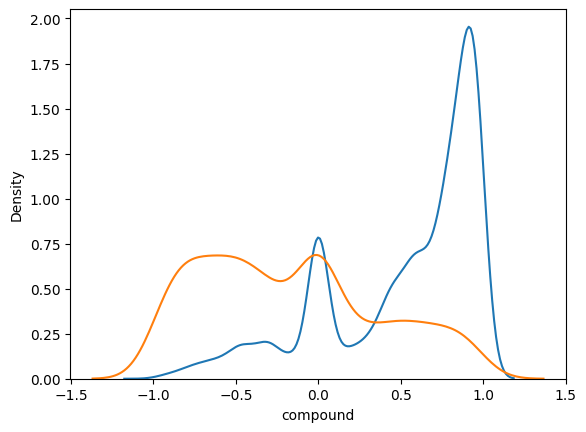

In [ ]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]

    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

# Modelling reviewer_score

In [ ]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [ ]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.033922
2,pos,0.024781
10,doc2vec_vector_4,0.021392
6,doc2vec_vector_0,0.021005
9,doc2vec_vector_3,0.020666
8,doc2vec_vector_2,0.019969
0,neg,0.019541
7,doc2vec_vector_1,0.018571
1,neu,0.015916
4,nb_chars,0.015827


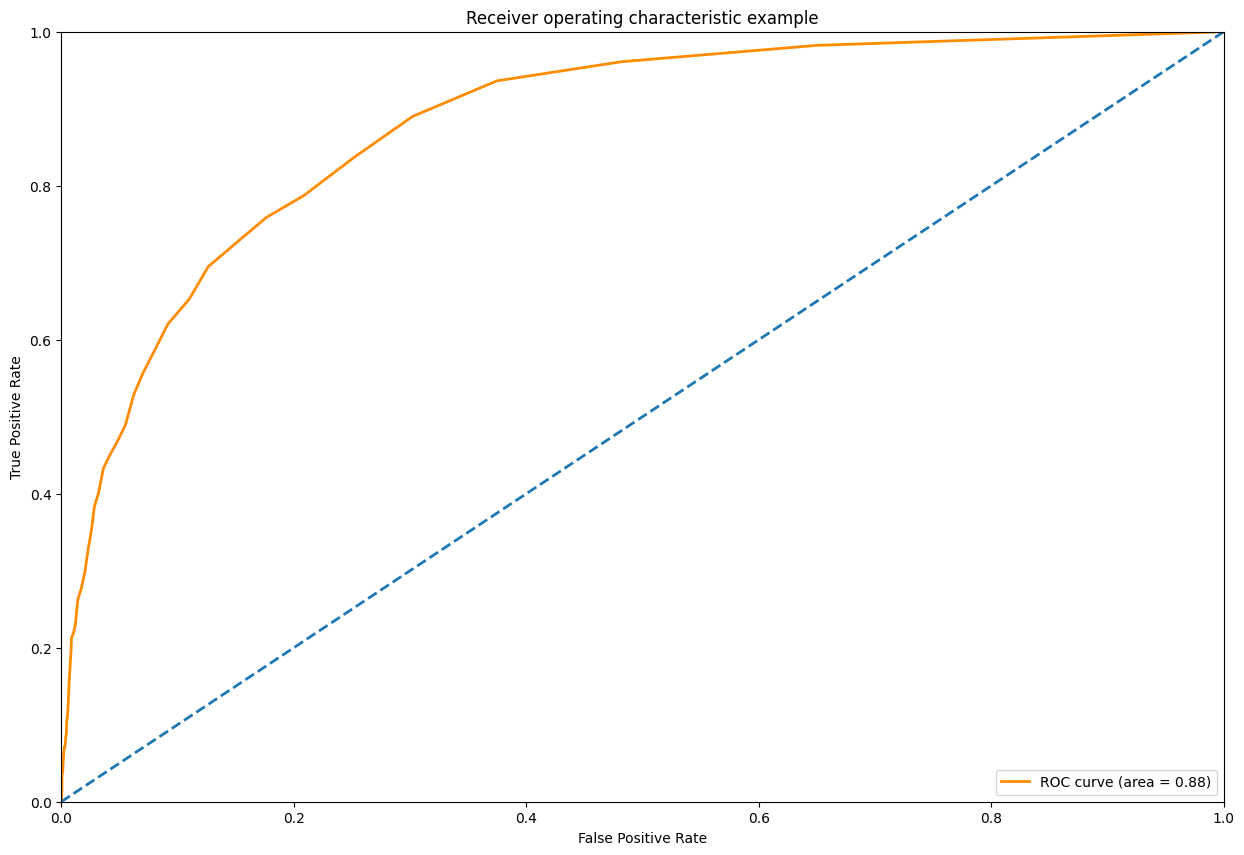

In [ ]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions. Although the AUC ROC (Area Under the Curve ROC) is very good, we should not use here the ROC curve to assess the quality of our model.

Why? First let us remind the False Positive Rate formula, which corresponds to the x axis of the ROC curve: FPR (False Positive Rate) = # False Positives / # Negatives.

Here the # Negatives corresponds to our number of good reviews which is very high because our dataset is imbalanced. This means that even with some False Positives, our FPR will tend to stay very low. Our model will be able to make a lot of false positives predictions and still have a low false positive rate, while increasing the true positive rate and therefore artificially increasing the AUC ROC metric.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.36')

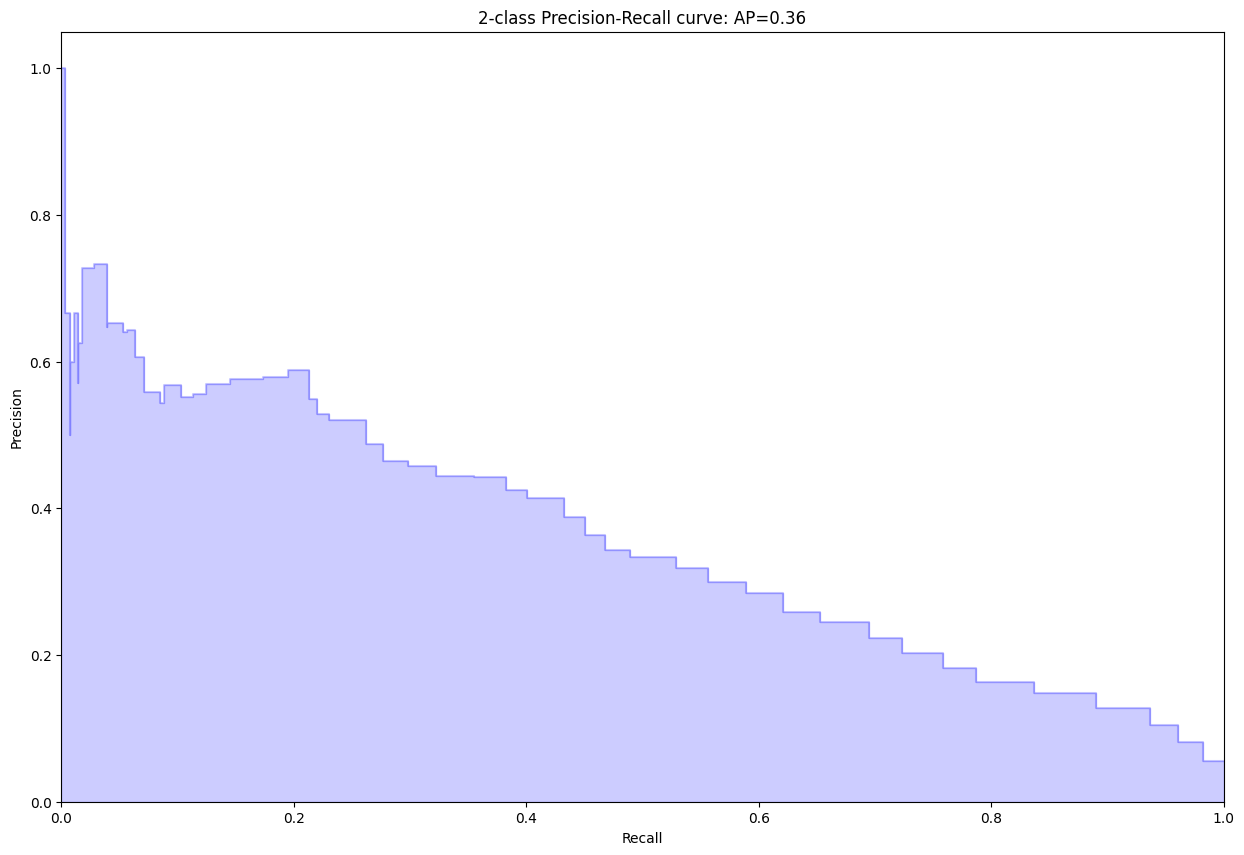

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

